In [ ]:
#!pip install -q tensorflow==2.3

In [ ]:
#!pip install albumentations -q

In [ ]:
#!pip install --upgrade pip

In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
!pip freeze > requirements.txt

# DATA

Types of variables:

* bodyType - categorical
* brand - categorical
* color - categorical
* description - string
* engineDisplacement - numerical, as string
* enginePower - numerical, as string
* fuelType - categorical
* mileage - numerical
* modelDate - numerical
* model_info - categorical
* name - categorical
* numberOfDoors - categorical
* price - numerical, *target value*
* productionDate - numerical
* sell_id - image 
* vehicleConfiguration - combination of several features
* vehicleTransmission - categorical
* Владельцы - categorical
* Владение - numerical, as string
* ПТС - categorical
* Привод - categorical
* Руль - categorical

In [6]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [8]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

# Model 1: "naive" model
The model predicts the price based on model and production date.  
It will be used as a baseline model.

In [10]:
# Splitting the data
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [11]:
# Naive model
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# Filling missing values 
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Rounding predicted values
predicts = (predicts // 1000) * 1000

# Evaluating model accuracy
print(f"MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

MAPE: 19.88%


# EDA

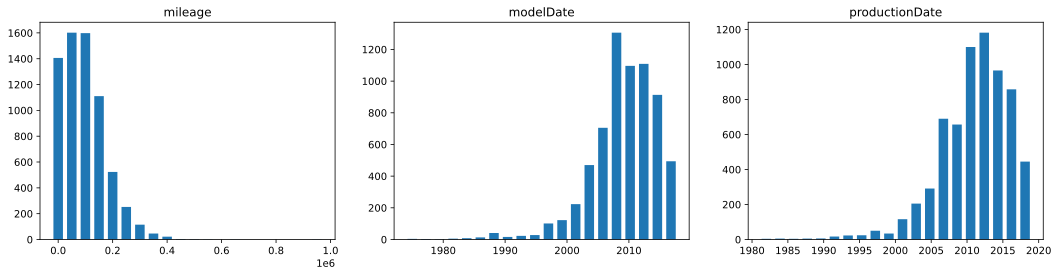

In [12]:
# Quick look at the distribution of numerical values
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

### PreProc Tabular Data

In [13]:
# Combining test and train
train['sample'] = 1 # mark train
test['sample'] = 0 # mark test
test['price'] = 0 # fill prices in test 

data = test.append(train, sort=False).reset_index(drop=True)
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [14]:
# Making a copy of combined dataset
data_copied = data.copy()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [16]:
data.nunique()

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 180
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
dtype: int64

In [17]:
# Checking for duplicates
data.duplicated().value_counts()   # no duplicates

False    8353
dtype: int64

In [18]:
for column in data.columns.to_list():
    print(column)
    display(pd.DataFrame(data[column].value_counts()).T)

bodyType


,седан,внедорожник 5 дв.,купе,хэтчбек 5 дв.,лифтбек,универсал 5 дв.,минивэн,купе-хардтоп,родстер,хэтчбек 3 дв.,кабриолет,компактвэн,лимузин,внедорожник 3 дв.,внедорожник открытый,пикап двойная кабина,седан 2 дв.
bodyType,3541,2896,543,364,299,196,178,111,88,57,54,8,5,5,4,3,1


brand


,BMW,MERCEDES,AUDI
brand,3535,2846,1972


color


,чёрный,белый,серый,синий,серебристый,коричневый,красный,голубой,зелёный,бежевый,фиолетовый,пурпурный,оранжевый,золотистый,жёлтый,розовый
color,3468,1607,925,863,420,386,266,91,86,85,46,38,30,24,17,1


description


,"Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудование \n• Запасные части \n• Сервисное обслуживание \n• Б/У шины и диски\n\nБолее 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ","• Автомобиль проверен по 110 пунктам\n• Автокредит по специальной ставке от 13,7%\n\nАуди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.\n\nНа протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.\nКаждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.\nЧтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.\nВы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.\nТакже Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуальных условиях. Специалисты компании подберут для Вас лучшие условия кредитования.\n\nБолее 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ","РОЛЬФ - Официальный дилер и Лучший дилер России по итогам продаж и обслуживания автомобилей. Мы гарантируем Вам самые лучшие условия покупки!\n\nВсе автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.\n∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.\n\nБолее 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ","РОЛЬФ Премиум – крупнейший официальный дилер Москвы\n\nВсе автомобили прошли:\n\n∙ Криминалистическую и юридическую проверку.\n∙ Комплексную диагностику, Вы получаете лист с официальным заключением о состоянии автомобиля.\n\nМы предлагаем:\n\n∙ Автокредит от 11,8% по двум документам одобрение за 1 час\n∙ Специальные условия при обмене на Ваш автомобиль\n∙ В наличии более 500 автомобилей с пробегом \n∙ Все автомобили прошли комплексную диагностику\n∙ Гарантия юридической чистоты\n∙ Более 150 комплектов колес и шин с пробегом по выгодной цене \n∙ Широкий ассортимент дополнительного оборудования\n∙ Уникальное предложение РОЛЬФ ""Авторефинансирование"".\n∙ Комиссия. Нашли машину сами - оформите кредит по специальной программе РОЛЬФ\n\nБолее 6 000 проверенных автомобилей с пробегом с гарантией до 2 лет ждут Вас на сайте rolf-probeg и в мобильном приложении Мой РОЛЬФ","Автодилер года 2020\n\nПобедитель в номинации «Организация продаж автомобилей с пробегом»\n\nИндивидуальные условия при покупке в кредит и/или при обмене на Ваш автомобиль.\nВсегда рады видеть Вас в нашем дилерском центре для просмотра д

engineDisplacement


,2.0 LTR,3.0 LTR,1.8 LTR,1.6 LTR,4.4 LTR,5.5 LTR,3.5 LTR,2.5 LTR,2.1 LTR,4.0 LTR,...,5.8 LTR,6.6 LTR,1.9 LTR,4.6 LTR,3.4 LTR,4.3 LTR,3.8 LTR,6.3 LTR,5.6 LTR,4.9 LTR
engineDisplacement,2430,2349,411,410,329,268,250,248,221,153,...,5,5,5,5,4,4,3,3,3,2


enginePower


,184 N12,249 N12,190 N12,245 N12,306 N12,211 N12,150 N12,170 N12,218 N12,156 N12,...,174 N12,165 N12,457 N12,100 N12,101 N12,166 N12,321 N12,114 N12,133 N12,591 N12
enginePower,759,655,420,355,344,310,278,274,233,223,...,1,1,1,1,1,1,1,1,1,1


fuelType


,бензин,дизель,гибрид,электро
fuelType,6018,2315,14,6


mileage


,120000,150000,180000,130000,140000,160000,170000,200000,110000,190000,...,156521,8585,86407,65925,280956,107800,80250,373,41329,102402
mileage,79,79,77,70,62,60,56,55,49,47,...,1,1,1,1,1,1,1,1,1,1


modelDate


,2011,2013,2014,2015,2009,2008,2012,2007,2016,2010,...,1979,1991,1977,1981,1975,1988,1993,1986,1971,1976
modelDate,830,739,667,656,655,562,548,542,467,407,...,4,4,2,2,2,2,1,1,1,1


model_info


,5ER,3ER,X5,E_KLASSE,A6,A4,S_KLASSE,7ER,C_KLASSE,X6,...,Z1,X3_M,COUPE,SQ7,CITAN,W201,SLC_KLASSE_AMG,100,W123,None
model_info,776,578,501,490,433,297,282,276,274,269,...,1,1,1,1,1,1,1,1,1,1


name


,35i 3.0 AT (306 л.с.) 4WD,2.0 AMT (211 л.с.) 4WD,200 2.0 AT (184 л.с.),30d 3.0d AT (249 л.с.) 4WD,400 3.0 AT (333 л.с.) 4WD,520i 2.0 AT (184 л.с.),2.0 CVT (180 л.с.),2.0 AMT (249 л.с.) 4WD,350 d 3.0d AT (249 л.с.) 4WD,320i xDrive 2.0 AT (184 л.с.) 4WD,...,119 BlueTEC L1 2.1d AT (190 л.с.) 4WD,63 AMG 4.0 AT (476 л.с.),30i 3.0 AT (258 л.с.),350 CDI BlueTEC 3.0d AT (258 л.с.),440i xDrive 3.0 AT (326 л.с.) 4WD,3.2 MT (250 л.с.) 4WD,30i 3.0 MT (231 л.с.) 4WD,50i 4.4 AT (462 л.с.) 4WD,320 Long 3.0d AT (235 л.с.) 4WD,Pullman 5.5 AT (500 л.с.)
name,151,145,137,109,97,86,81,80,80,77,...,1,1,1,1,1,1,1,1,1,1


numberOfDoors


,5,4,2,3
numberOfDoors,3854,3636,802,61


productionDate


,2013,2011,2014,2012,2016,2015,2017,2018,2008,2010,...,1990,1985,1986,1988,1982,1984,1991,1983,1989,1987
productionDate,783,702,693,680,600,599,562,529,510,468,...,10,4,4,4,3,3,2,2,1,1


sell_id


,1099612970,1055208716,1099093264,1098720534,1099863320,1099631944,1099687198,1093392156,1100128288,1099867430,...,1100032632,1099538340,1096792698,1100202816,1100077694,1100249730,1084457605,1099623048,1099300402,1097908224
sell_id,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


vehicleConfiguration


,ALLROAD_5_DOORS AUTOMATIC 3.0,SEDAN AUTOMATIC 2.0,SEDAN AUTOMATIC 3.0,ALLROAD_5_DOORS AUTOMATIC 2.0,ALLROAD_5_DOORS ROBOT 2.0,ALLROAD_5_DOORS AUTOMATIC 4.4,SEDAN AUTOMATIC 2.5,ALLROAD_5_DOORS AUTOMATIC 5.5,SEDAN AUTOMATIC 1.6,SEDAN VARIATOR 2.0,...,CABRIO AUTOMATIC 4.7,COUPE AUTOMATIC 2.9,LIFTBACK ROBOT 3.2,ROADSTER AUTOMATIC 1.9,SEDAN AUTOMATIC 5.8,CABRIO AUTOMATIC 1.8,COUPE_HARDTOP AUTOMATIC 2.2,COUPE AUTOMATIC 5.6,ROADSTER MECHANICAL 1.9,COUPE MECHANICAL 3.4
vehicleConfiguration,1292,941,631,524,226,168,152,139,131,123,...,1,1,1,1,1,1,1,1,1,1


vehicleTransmission


,автоматическая,роботизированная,вариатор,механическая
vehicleTransmission,6560,1201,406,186


Владельцы


,3 или более,1 владелец,2 владельца
Владельцы,3311,2526,2515


Владение


,1 год и 8 месяцев,1 год и 2 месяца,1 год,9 месяцев,1 год и 10 месяцев,2 года и 2 месяца,1 год и 11 месяцев,1 год и 4 месяца,1 год и 5 месяцев,3 года,...,15 лет и 10 месяцев,16 лет и 1 месяц,27 лет и 10 месяцев,13 лет и 3 месяца,11 лет и 1 месяц,19 лет,29 лет и 7 месяцев,17 лет и 4 месяца,18 лет и 7 месяцев,14 лет и 5 месяцев
Владение,67,67,55,52,52,52,51,51,51,49,...,1,1,1,1,1,1,1,1,1,1


ПТС


,Оригинал,Дубликат
ПТС,7474,879


Привод


,полный,задний,передний
Привод,5218,2259,876


Руль


,Левый,Правый
Руль,8351,2


sample


,1,0
sample,6682,1671


price


,0.0,950000.0,1100000.0,1200000.0,850000.0,1150000.0,750000.0,1050000.0,900000.0,1250000.0,...,3570000.0,3768000.0,3899000.0,4390000.0,2015000.0,3195000.0,685850.0,13498000.0,1294000.0,1594000.0
price,1671,76,73,71,68,68,66,65,65,64,...,1,1,1,1,1,1,1,1,1,1


In [19]:
data[data['model_info']=='None'] # one None value in model_info, is left as it is, since encoding will be applied to this column

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0 LTR,510 N12,бензин,41000,2014,None,...,1099323364,SEDAN AUTOMATIC 4.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,1,3700000.0


In [20]:
# Values in engineDisplacement are converted to numerical. 
# Several electro cars (without gas engine) present. New feature 'is_electro' is created to save this information.
data['engineDisplacement'].value_counts()
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 0 if x == 'undefined LTR' else float(x[:-4]))
data['is_electro'] = data['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

In [21]:
data[data['sample']==1][['engineDisplacement', 'price']].corr() # considerable correlation with price

,engineDisplacement,price
engineDisplacement,1.000000,0.288273
price,0.288273,1.000000


In [22]:
# Converting values in enginePower to numerical
data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4]))

In [23]:
data[data['sample']==1][['enginePower', 'price']].corr() # high correlation with price

,enginePower,price
enginePower,1.000000,0.491205
price,0.491205,1.000000


In [24]:
# Number of previous owners
data[data['Владельцы'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,is_electro
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2,360,бензин,160000,1999,S8,...,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,600000.0,0


In [25]:
# Checking for missing data in description
data[data['Владельцы'].isna()]['description'].values # no helpful information

array(['машина в идеале! вложено примерно 400тыс.руб \r\n замена ГРМ, всех расходников,\r\n двигатель контрактный с пробегом в 120,000км.\r\n рулевая рейка новая (не ремонтная а НОВАЯ!)\r\n новый кардан. \r\n новые гидро натяжители цепей 40тыс.руб. \r\n новый бензонасос, \r\n новая подвеска "бильштайн" \r\n и т.д. \r\n комплектация максимальная- черное дерево! штатный (снимаемый) фаркоп, предпусковой подогреватель WEBASTO, кованные диски (германия) R-20, телефон.\r\nНА ВТОРОМ ФОТО СТАРЫЙ РУЛЬ! СЕЙЧАС НОВЫЙ С ДЕРЕВОМ КАК НА ПОСЛЕДНИХ ФОТО... (старый отдам в довесок)\r\nнедавно сделана полная разводка глушителей, с установкой новых банок на обе трубы (на фото можно разглядеть снизу) банки от ренж ровер спорт, звук КЛАСС!!!\r\n много писать, звоните...\r\nфото 100% мои!\r\nвозможен обмен на битый или горевший  микроавтобус (фольксваген Т-5) мультиван свежих годов.\r\nСАЛОНЫ И ПРОЧИЕ "ПОМОЩНИКИ" ИДИТЕ ЛЕСОМ!!!!!!!!!\r\nфото 100% мои!\r\nпродажа НЕ срочная!!! с большим торгом не звонить.'],

In [26]:
data['Владельцы'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [27]:
# Filling the gap with the most common value
data['Владельцы'].fillna('3 или более', inplace=True)

In [28]:
# Converting values in Владельцы to numerical
data['owners'] = data['Владельцы'].apply(lambda x: int(x[0]))

In [29]:
data[['owners', 'price']].corr()

,owners,price
owners,1.000000,-0.309139
price,-0.309139,1.000000


In [30]:
# Duration of ownership
data[data['Владение'].isna()]['Владение'] # missing values in more than a half instances

2       NaN
3       NaN
4       NaN
6       NaN
9       NaN
       ... 
8346    NaN
8347    NaN
8348    NaN
8351    NaN
8352    NaN
Name: Владение, Length: 5418, dtype: object

In [31]:
data['Владение'].fillna('no data', inplace=True)

In [32]:
# Where duration of ownership is known, converting to number of months
def own_period(row):  
    if str(row['Владение']) == 'no data':
        return 0
    if 'год' in row['Владение']:
        year = row['Владение'][:row['Владение'].find(' год')]
    elif 'лет' in row['Владение']:
        year = row['Владение'][:row['Владение'].find(' лет')]
    else:
        year = 0

    if ' и ' in row['Владение']:
        month = row['Владение'][row['Владение'].find(' и')+2:row['Владение'].find(' мес')][1:]    
    elif 'мес' in row['Владение']:
        month = row['Владение'][:row['Владение'].find(' мес')]
    else:
        month = 0
    return int(year)*12 + int(month)

data['own_period'] = data.apply(own_period, axis=1)

In [33]:
data[data['sample']==1][['price', 'own_period']].corr() # there is somewhat correlation between known duration of ownership and price

,price,own_period
price,1.000000,-0.102642
own_period,-0.102642,1.000000


In [34]:
data['own_period'].value_counts() # since there are too many gaps, encoding will be applied

0      5418
20       67
14       67
12       55
26       52
       ... 
280       1
138       1
215       1
234       1
223       1
Name: own_period, Length: 181, dtype: int64

### New Features

In [35]:
# Popular color: black or white
data['pop_color'] = data['color'].apply(lambda x: 1 if (x=='черный' or x=='белый') else 0)

In [36]:
data['pop_color'].value_counts()

0    6746
1    1607
Name: pop_color, dtype: int64

In [37]:
data['productionDate'].max()

2020

In [38]:
data['productionDate'].value_counts()

2013    783
2011    702
2014    693
2012    680
2016    600
2015    599
2017    562
2018    529
2008    510
2010    468
2019    449
2009    345
2007    343
2006    182
2005    170
2004    155
2020    100
2003    100
2002     78
2001     73
1999     45
2000     43
1998     24
1997     21
1994     15
1995     14
1992     12
1996     12
1993     12
1990     10
1985      4
1986      4
1988      4
1982      3
1984      3
1991      2
1983      2
1989      1
1987      1
Name: productionDate, dtype: int64

In [39]:
data['mileage'].value_counts()

120000    79
150000    79
180000    77
130000    70
140000    62
          ..
107800     1
80250      1
373        1
41329      1
102402     1
Name: mileage, Length: 3507, dtype: int64

In [40]:
data['modelDate'].max()

2019

In [41]:
# How new was the model when was produced
data['modelAge'] = data['productionDate'] - data['modelDate']
data['modelAge'].value_counts()

1     2403
2     2330
3     1584
0     1144
4      686
5      116
6       26
7       15
11      12
8       10
9        9
12       6
14       4
13       2
10       2
15       2
18       1
16       1
Name: modelAge, dtype: int64

In [42]:
data[['modelAge', 'price']].corr()

,modelAge,price
modelAge,1.000000,-0.019374
price,-0.019374,1.000000


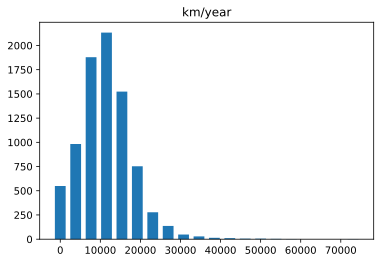

In [43]:
# Average kms per year
data['km_per_year'] = data['mileage']/(2021 - data['productionDate'])
visualize_distributions({'km/year': data['km_per_year']})

In [44]:
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 'Привод',]

In [45]:
numerical_features = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'owners', 'km_per_year',]

In [46]:
binary_features = ['ПТС', 'Руль']

In [47]:
# Combining all transformation in one function for easy application
### The following function does not include new feature "modelAge", as tests showed that better accuracy was reached without it
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Preprocessing ############################################################## 

    
    # ################### Filling missing values ########################################################
    df_output['Владельцы'].fillna('3 или более', inplace=True)
    df_output['Владение'].fillna('no data', inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    df_output['owners'] = df_output['Владельцы'].fillna('3 или более').apply(lambda x: int(x[0]))
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x[:-4]))
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: 0 if x == 'undefined LTR' else float(x[:-4]))
    
    
    # ################### Categorical Features ############################################################## 

    # One-Hot Encoding:
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # Label Encoding:
    for feature in binary_features:
        df_output[feature] = df_output[feature].astype('category').cat.codes
    
    
    # ################### 2. Feature Engineering ####################################################
    
    df_output['pop_color'] = df_input['color'].apply(lambda x: 1 if (x=='черный' or x=='белый') else 0)
    
    df_output['km_per_year'] = df_output['mileage']/(2021 - df_output['productionDate'])
    
    df_output['own_period'] = df_output['Владение'].apply(lambda x: x if str(x) == 'no data' else 1)
    
    for i in range(len(df_output)):
        if df_output['own_period'][i] == 1:
            if 'год' in df_output['Владение'][i]:
                year = df_output['Владение'][i][:df_output['Владение'][i].find(' год')]
            elif 'лет' in df_output['Владение'][i]:
                year = df_output['Владение'][i][:df_output['Владение'][i].find(' лет')]
            else:
                year = 0
            if ' и ' in df_output['Владение'][i]:
                month = df_output['Владение'][i][df_output['Владение'][i].find(' и')+2:df_output['Владение'][i].find(' мес')][1:]    
            elif 'мес' in df_output['Владение'][i]:
                month = df_output['Владение'][i][:df_output['Владение'][i].find(' мес')]
            else:
                month = 0
            df_output['own_period'][i] = int(int(year)*12 + int(month))
            
    df_output = pd.get_dummies(df_output, columns=['own_period'], dummy_na=False)

    df_output['is_electro'] = df_output['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

    # ################### 3. Normalization #################################################### 
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        df_output[column] = np.log(df_output[column].max() - df_output[column] +0.001)
    
    # ################### 4. Cleaning #################################################### 
    df_output.drop(['Владение', 'Владельцы', 'description', 'sell_id', 'vehicleConfiguration', 'name'], axis = 1, inplace=True)    
    
    return df_output

In [48]:
data_proc = test.append(train, sort=False).reset_index(drop=True)
df_preproc = preproc_data(data_proc)
df_preproc.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,engineDisplacement,enginePower,mileage,modelDate,productionDate,ПТС,Руль,sample,price,owners,...,own_period_225,own_period_226,own_period_228,own_period_234,own_period_257,own_period_280,own_period_334,own_period_355,own_period_no data,is_electro
7399,-0.359580,-0.316082,-0.112049,-2.252209,-2.020577,1,0,1,1590000.0,0.001000,...,0,0,0,0,0,0,0,0,0,0
4273,-0.359580,-0.316082,-0.044996,-2.071473,-2.241837,1,0,1,3100000.0,0.001000,...,0,0,0,0,0,0,0,0,0,0
3362,-1.785777,-1.687399,-0.055512,-2.071473,-2.020577,1,0,1,3750000.0,-6.907755,...,0,0,0,0,0,0,0,0,1,0
2794,-0.604304,-0.316082,-0.132388,-1.785777,-1.436148,1,0,1,1990000.0,-6.907755,...,0,0,0,0,0,0,0,0,1,0
5378,-0.359580,-0.258512,-0.160168,-2.071473,-2.020577,1,0,1,1285000.0,-6.907755,...,0,0,0,0,0,0,0,0,1,0
5902,-0.929023,-1.491655,-0.071280,-1.918457,-1.686262,1,0,1,3399999.0,0.001000,...,0,0,0,0,0,0,0,0,1,0
1454,-0.604304,-0.495937,-0.053153,-1.918457,-2.020577,1,0,0,0.0,-0.691149,...,0,0,0,0,0,0,0,0,1,0
2476,-0.474474,-0.258512,-0.189345,-1.382302,-1.149518,0,0,1,700000.0,-6.907755,...,0,0,0,0,0,0,0,0,0,0
743,-0.276313,-0.065072,-0.126697,-1.382302,-1.331208,1,0,0,0.0,-6.907755,...,0,0,0,0,0,0,0,0,1,0
1168,-1.785777,-1.383897,-0.035626,-1.918457,-1.839513,1,0,0,0.0,-6.907755,...,0,0,0,0,0,0,0,0,1,0


In [49]:
df_preproc.columns.to_list()

['engineDisplacement',
 'enginePower',
 'mileage',
 'modelDate',
 'productionDate',
 'ПТС',
 'Руль',
 'sample',
 'price',
 'owners',
 'bodyType_внедорожник 3 дв.',
 'bodyType_внедорожник 5 дв.',
 'bodyType_внедорожник открытый',
 'bodyType_кабриолет',
 'bodyType_компактвэн',
 'bodyType_купе',
 'bodyType_купе-хардтоп',
 'bodyType_лимузин',
 'bodyType_лифтбек',
 'bodyType_минивэн',
 'bodyType_пикап двойная кабина',
 'bodyType_родстер',
 'bodyType_седан',
 'bodyType_седан 2 дв.',
 'bodyType_универсал 5 дв.',
 'bodyType_хэтчбек 3 дв.',
 'bodyType_хэтчбек 5 дв.',
 'brand_AUDI',
 'brand_BMW',
 'brand_MERCEDES',
 'color_бежевый',
 'color_белый',
 'color_голубой',
 'color_жёлтый',
 'color_зелёный',
 'color_золотистый',
 'color_коричневый',
 'color_красный',
 'color_оранжевый',
 'color_пурпурный',
 'color_розовый',
 'color_серебристый',
 'color_серый',
 'color_синий',
 'color_фиолетовый',
 'color_чёрный',
 'fuelType_бензин',
 'fuelType_гибрид',
 'fuelType_дизель',
 'fuelType_электро',
 'model_i

In [50]:
data_proc_copied = df_preproc.copy()

In [51]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 367 entries, engineDisplacement to is_electro
dtypes: float64(8), int64(3), int8(2), uint8(354)
memory usage: 3.5 MB


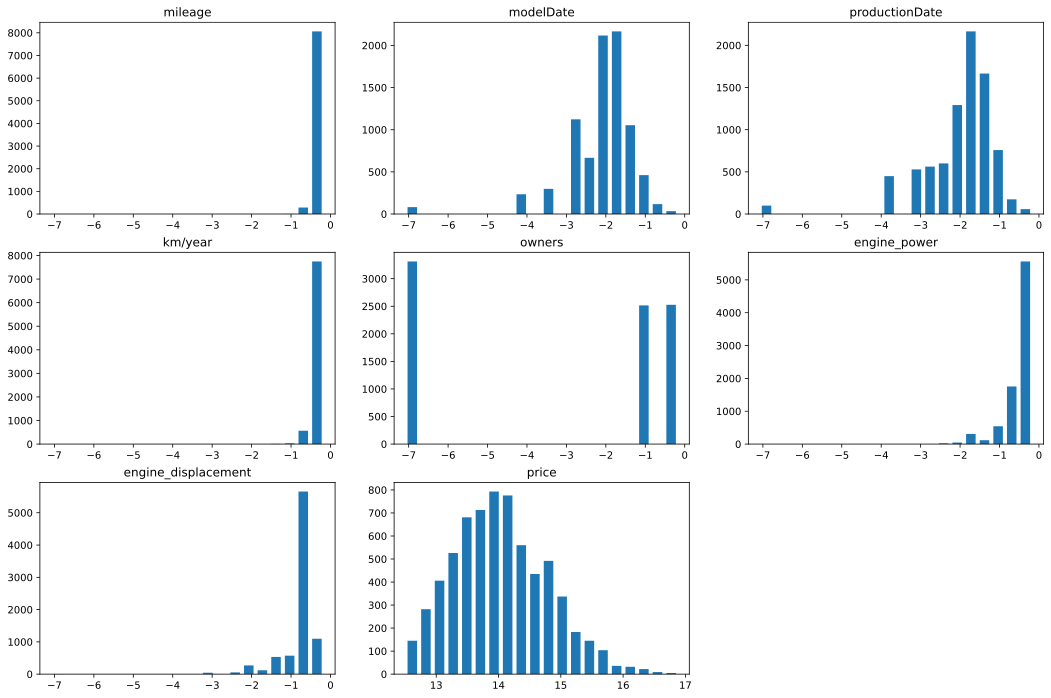

In [52]:
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': df_preproc['mileage'],
    'modelDate': df_preproc['modelDate'],
    'productionDate': df_preproc['productionDate'],
    'km/year': df_preproc['km_per_year'],
    'owners': df_preproc['owners'],
    'engine_power': df_preproc['enginePower'],
    'engine_displacement': df_preproc['engineDisplacement'],
    'price': np.log(df_preproc[df_preproc['sample']==1]['price'])
    
})

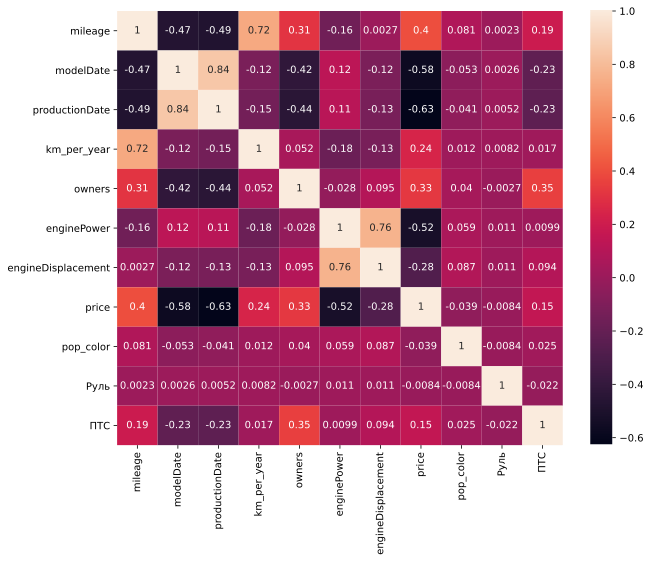

In [53]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,8)
sns.heatmap((df_preproc[df_preproc['sample']==1][['mileage', 'modelDate', 'productionDate', 'km_per_year',
                                                  'owners', 'enginePower', 'engineDisplacement', 'price', 'pop_color', 'Руль', 'ПТС']]).corr(), annot=True)

In [54]:
# Splitting the data
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # target value
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

# Model 2: CatBoostRegressor

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [56]:
# Choosing the optimal depth
cbr_c = {'num_trees': [], 'mape_test': [], 'mape_train': []}

num_trees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for depth in num_trees:
    model = CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED, eval_metric='MAPE', custom_metric=['RMSE', 'MAE'],
                              silent=True, learning_rate=0.1, depth=depth)
    model.fit(X_train, np.log(y_train), eval_set=(X_test, np.log(y_test)),
              verbose_eval=0, use_best_model=True,)
    predict_test = np.exp(model.predict(X_test))
    predict_train = np.exp(model.predict(X_train))
    cbr_c['num_trees'].append(depth)
    cbr_c['mape_test'].append(round((mape(y_test, predict_test))*100, 2))
    cbr_c['mape_train'].append(round((mape(y_train, predict_train))*100, 2))
    
cbr_df = pd.DataFrame.from_dict(cbr_c)
cbr_df    

,num_trees,mape_test,mape_train
0,1,13.19,12.63
1,2,11.46,9.51
2,3,11.22,9.16
3,4,11.19,8.88
4,5,11.39,7.92
5,6,11.51,7.89
6,7,11.33,7.85
7,8,11.47,7.41
8,9,11.19,6.73
9,10,11.29,6.14


In [57]:
# depth = 4
model_cbr = CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED, eval_metric='MAPE', custom_metric=['RMSE', 'MAE'], 
                          silent=True, learning_rate=0.1, depth=4)
model_cbr.fit(X_train, np.log(y_train), eval_set=(X_test, np.log(y_test)), verbose_eval=0, use_best_model=True,)
test_predict_catboost = np.exp(model_cbr.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.19%


In [58]:
sub_predict_catboost = np.exp(model_cbr.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('sample_submission_catboost.csv', index=False)

# Model 3: Tabular NN

## Simple Dense NN

In [60]:
del model

In [63]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               187392    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 318,977
Trainable params: 318,977
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [66]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [67]:
history = model.fit(X_train, np.log(y_train),
                    batch_size=512,
                    epochs=500, # or less if EarlyStopping brings to stop learning
                    validation_data=(X_test, np.log(y_test)),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

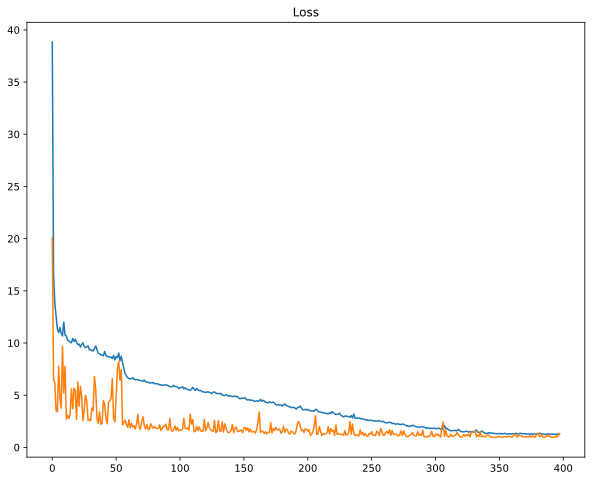

In [68]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [69]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [71]:
test_predict_nn1 = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 17.20%


In [73]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [74]:
data['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [75]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [76]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [77]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.47 s, sys: 5.46 ms, total: 1.47 s
Wall time: 1.48 s


In [78]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.67 s, sys: 3.84 ms, total: 1.67 s
Wall time: 1.68 s


In [79]:
# Example of tokenized text
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [80]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [81]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [82]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being the regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [83]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [84]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [85]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [86]:
history = model.fit([text_train_sequences, X_train], np.log(y_train),
                    batch_size=512,
                    epochs=500, 
                    validation_data=([text_test_sequences, X_test], np.log(y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 433ms/step - loss: 41.7795 - MAPE: 41.7795 - val_loss: 6.5212 - val_MAPE: 6.5212
Epoch 2/500
12/12 [==============================] - 5s 383ms/step - loss: 15.3354 - MAPE: 15.3354 - val_loss: 4.9524 - val_MAPE: 4.9524
Epoch 3/500
12/12 [==============================] - 4s 352ms/step - loss: 11.6175 - MAPE: 11.6175 - val_loss: 3.8168 - val_MAPE: 3.8168
Epoch 4/500
12/12 [==============================] - 4s 367ms/step - loss: 9.9727 - MAPE: 9.9727 - val_loss: 4.1334 - val_MAPE: 4.1334
Epoch 5/500
12/12 [==============================] - 4s 347ms/step - loss: 9.5449 - MAPE: 9.5449 - val_loss: 7.4319 - val_MAPE: 7.4319
Epoch 6/500
12/12 [==============================] - 4s 361ms/step - loss: 9.4085 - MAPE: 9.4085 - val_loss: 2.5791 - val_MAPE: 2.5791
Epoch 7/500
12/12 [==============================] - 4s 348ms/step - loss: 8.7120 - MAPE: 8.7120 - val_loss: 3.0424 - val_MAPE: 3.0424
Epoch 8/500
12/12 [==============================

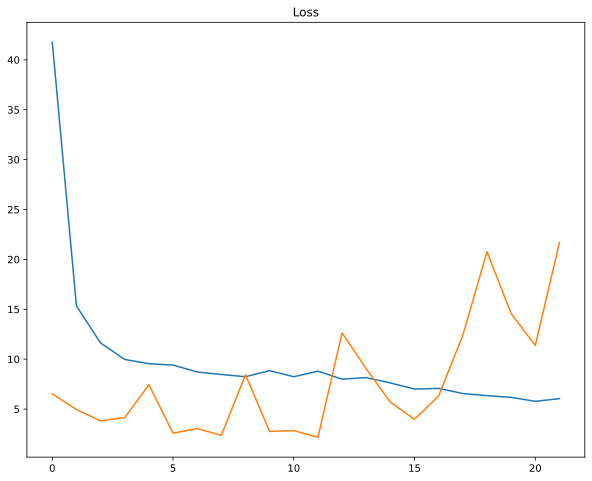

In [87]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [88]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [89]:
test_predict_nn2 = np.exp(model.predict([text_test_sequences, X_test]))
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 95.07%


In [90]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

### Text preprocessing

In [91]:
data_text = data[['description', 'sample', 'price']]

In [92]:
data_text['description'][1]

'Продаю любимейшую тачилу.. Обвес и тюнинг Hamman. Потому что совсем на ней не езжу, а она должна резвиться и служить. Авто с хорошей кармой. С хорошим звуком и вообще приятнейшая. \n\nИз-за частых командировок машиной не пользовалась, отсюда и такой маленький пробег. Были 2 мелких аварии (не увидела столбик во дворе и ещё раз не увидела, но сделала ремонт и все части поврежденные отремонтировала).\n\nНа фото летняя резина на родных дисках, а у меня есть ещё зимняя резина на супер красивых дисках! Отдам вместе с машиной бонусом. Если купит девушка - то с меня патчи и блеск для губ ❤️'

In [93]:
data_text['description'] = data_text['description'].apply(lambda x: x.replace('\n', ' ').lower())
data_text['description'] = data_text['description'].apply(lambda x: x.replace('\t', ' '))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
data_text['description'][1]

'продаю любимейшую тачилу.. обвес и тюнинг hamman. потому что совсем на ней не езжу, а она должна резвиться и служить. авто с хорошей кармой. с хорошим звуком и вообще приятнейшая.   из-за частых командировок машиной не пользовалась, отсюда и такой маленький пробег. были 2 мелких аварии (не увидела столбик во дворе и ещё раз не увидела, но сделала ремонт и все части поврежденные отремонтировала).  на фото летняя резина на родных дисках, а у меня есть ещё зимняя резина на супер красивых дисках! отдам вместе с машиной бонусом. если купит девушка - то с меня патчи и блеск для губ ❤️'

In [95]:
for i in range(data_text.shape[0]):
    new_list = []
    for item in data_text['description'][i].split(' '):
        new_item = ''.join(re.findall(r'[a-zа-я]', item))
        if new_item == []:
            continue
        new_list.append(new_item)
    data_text['description'][i] = ' '.join(new_list)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [96]:
data_text['description'][1]

'продаю любимейшую тачилу обвес и тюнинг hamman потому что совсем на ней не езжу а она должна резвиться и служить авто с хорошей кармой с хорошим звуком и вообще приятнейшая   изза частых командировок машиной не пользовалась отсюда и такой маленький пробег были  мелких аварии не увидела столбик во дворе и ещ раз не увидела но сделала ремонт и все части поврежденные отремонтировала  на фото летняя резина на родных дисках а у меня есть ещ зимняя резина на супер красивых дисках отдам вместе с машиной бонусом если купит девушка  то с меня патчи и блеск для губ '

In [97]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [98]:
from pymystem3 import Mystem
mystem = Mystem() 
data_text['description'] = data_text['description'].apply(lambda x: ''.join(mystem.lemmatize(x))[:-1])

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
data_text['description'][1]

'продавать любимый тачил обвес и тюнинг hamman потому что совсем на она не ездить а она должный резвиться и служить авто с хороший карма с хороший звук и вообще приятный   изза частый командировка машина не пользоваться отсюда и такой маленький пробег быть  мелкий авария не увидеть столбик во двор и ещ раз не увидеть но сделать ремонт и весь часть повреждать отремонтировать  на фото летний резина на родной диск а у я быть ещ зимний резина на супер красивый диск отдавать вместе с машина бонус если купить девушка  то с я патч и блеск для губа '

In [100]:
data_text['description'] = data_text['description'].apply(lambda x: x.split(' '))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
data_text['description'][1]

['продавать',
 'любимый',
 'тачил',
 'обвес',
 'и',
 'тюнинг',
 'hamman',
 'потому',
 'что',
 'совсем',
 'на',
 'она',
 'не',
 'ездить',
 'а',
 'она',
 'должный',
 'резвиться',
 'и',
 'служить',
 'авто',
 'с',
 'хороший',
 'карма',
 'с',
 'хороший',
 'звук',
 'и',
 'вообще',
 'приятный',
 '',
 '',
 'изза',
 'частый',
 'командировка',
 'машина',
 'не',
 'пользоваться',
 'отсюда',
 'и',
 'такой',
 'маленький',
 'пробег',
 'быть',
 '',
 'мелкий',
 'авария',
 'не',
 'увидеть',
 'столбик',
 'во',
 'двор',
 'и',
 'ещ',
 'раз',
 'не',
 'увидеть',
 'но',
 'сделать',
 'ремонт',
 'и',
 'весь',
 'часть',
 'повреждать',
 'отремонтировать',
 '',
 'на',
 'фото',
 'летний',
 'резина',
 'на',
 'родной',
 'диск',
 'а',
 'у',
 'я',
 'быть',
 'ещ',
 'зимний',
 'резина',
 'на',
 'супер',
 'красивый',
 'диск',
 'отдавать',
 'вместе',
 'с',
 'машина',
 'бонус',
 'если',
 'купить',
 'девушка',
 '',
 'то',
 'с',
 'я',
 'патч',
 'и',
 'блеск',
 'для',
 'губа',
 '']

In [102]:
from nltk.corpus import stopwords
print(stopwords.words("russian"))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [103]:
for i in range(data_text.shape[0]):
    new_list = []
    for item in data_text['description'][i]:
        if (item in stopwords.words("russian")) or (item == ''):
            continue
        new_list.append(item)
    data_text['description'][i] = new_list

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [104]:
data_text['description'][1]

['продавать',
 'любимый',
 'тачил',
 'обвес',
 'тюнинг',
 'hamman',
 'ездить',
 'должный',
 'резвиться',
 'служить',
 'авто',
 'хороший',
 'карма',
 'хороший',
 'звук',
 'вообще',
 'приятный',
 'изза',
 'частый',
 'командировка',
 'машина',
 'пользоваться',
 'отсюда',
 'маленький',
 'пробег',
 'мелкий',
 'авария',
 'увидеть',
 'столбик',
 'двор',
 'ещ',
 'увидеть',
 'сделать',
 'ремонт',
 'весь',
 'часть',
 'повреждать',
 'отремонтировать',
 'фото',
 'летний',
 'резина',
 'родной',
 'диск',
 'ещ',
 'зимний',
 'резина',
 'супер',
 'красивый',
 'диск',
 'отдавать',
 'вместе',
 'машина',
 'бонус',
 'купить',
 'девушка',
 'патч',
 'блеск',
 'губа']

In [105]:
word_dict = {}

for i in range(data_text.shape[0]):
    for word in data_text['description'][i]:
        if (word == '') or (word == '⠀'):
            continue
        if word in word_dict.keys():
            word_dict[word] = word_dict[word] + 1
        else:
            word_dict[word] = 1

In [106]:
len(word_dict)

23926

In [107]:
i=0
for key, value in word_dict.items():
    if word_dict[key] >= 2:
        i+=1
print(i)


10207


In [108]:
data_text['description'][1]

['продавать',
 'любимый',
 'тачил',
 'обвес',
 'тюнинг',
 'hamman',
 'ездить',
 'должный',
 'резвиться',
 'служить',
 'авто',
 'хороший',
 'карма',
 'хороший',
 'звук',
 'вообще',
 'приятный',
 'изза',
 'частый',
 'командировка',
 'машина',
 'пользоваться',
 'отсюда',
 'маленький',
 'пробег',
 'мелкий',
 'авария',
 'увидеть',
 'столбик',
 'двор',
 'ещ',
 'увидеть',
 'сделать',
 'ремонт',
 'весь',
 'часть',
 'повреждать',
 'отремонтировать',
 'фото',
 'летний',
 'резина',
 'родной',
 'диск',
 'ещ',
 'зимний',
 'резина',
 'супер',
 'красивый',
 'диск',
 'отдавать',
 'вместе',
 'машина',
 'бонус',
 'купить',
 'девушка',
 'патч',
 'блеск',
 'губа']

In [109]:
# split данных
text_train = data_text['description'].iloc[X_train.index]
text_test = data_text['description'].iloc[X_test.index]
text_sub = data_text['description'].iloc[X_sub.index]

#%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_text['description'])

#%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

        

(5679, 256) (1003, 256) (1671, 256)


In [110]:
# Example of tokenized text
print(text_train.iloc[2])
print(text_train_sequences[2])

['внимание', 'клиент', 'avilon', 'автомобиль', 'пробег', 'предлагать', 'специальный', 'кредитный', 'программа', 'гарантия', 'минимальный', 'ежемесячный', 'платеж', 'условие', 'кредитование', 'первоначальный', 'взнос', 'размер', 'процентный', 'ставка', 'сниженияперерасчет', 'конец', 'срок', 'кредит', 'срок', 'кредит', 'месяц', 'год', 'увеличивать', 'дополнительный', 'скидка', 'р', 'обмен', 'свой', 'автомобиль', 'наш', 'система', 'tradein', 'р', 'оформление', 'кредит', 'снижать', 'ставка', 'банкапартнр', 'полис', 'каско', 'весь', 'скидка', 'спецпредложение', 'суммироваться', 'автомобиль', 'audi', 'a', 'avilon', 'автомобиль', 'пробег', 'обслуживание', 'предпродажный', 'подготовка', 'сертифицировать', 'сервисный', 'станция', 'предоставление', 'официальный', 'диагностика', 'обязательный', 'юридический', 'проверка', 'автомобиль', 'обеспечивать', 'полный', 'прозрачность', 'сервисный', 'история', 'исключать', 'наличие', 'финансовый', 'обременение', 'купить', 'продавать', 'любой', 'авто', 'офиц

In [111]:
history = model.fit([text_train_sequences, X_train], np.log(y_train),
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], np.log(y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 371ms/step - loss: 6.5585 - MAPE: 6.5585 - val_loss: 19.8991 - val_MAPE: 19.8991
Epoch 2/500
12/12 [==============================] - 5s 381ms/step - loss: 5.8960 - MAPE: 5.8960 - val_loss: 13.8671 - val_MAPE: 13.8671
Epoch 3/500
12/12 [==============================] - 4s 349ms/step - loss: 5.4020 - MAPE: 5.4020 - val_loss: 13.4880 - val_MAPE: 13.4880
Epoch 4/500
12/12 [==============================] - 4s 353ms/step - loss: 5.2304 - MAPE: 5.2304 - val_loss: 18.3516 - val_MAPE: 18.3516
Epoch 5/500
12/12 [==============================] - 4s 347ms/step - loss: 5.0455 - MAPE: 5.0455 - val_loss: 17.7815 - val_MAPE: 17.7815
Epoch 6/500
12/12 [==============================] - 4s 347ms/step - loss: 4.9391 - MAPE: 4.9391 - val_loss: 14.3579 - val_MAPE: 14.3579
Epoch 7/500
12/12 [==============================] - 4s 349ms/step - loss: 4.9436 - MAPE: 4.9436 - val_loss: 18.3534 - val_MAPE: 18.3534
Epoch 8/500
12/12 [======================

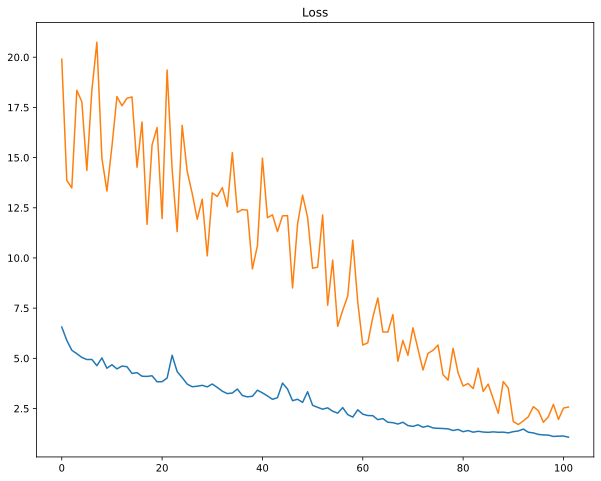

In [112]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [113]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [114]:
test_predict_nn2 = np.exp(model.predict([text_test_sequences, X_test]))
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 30.05%


In [115]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: + Image processing

### Data

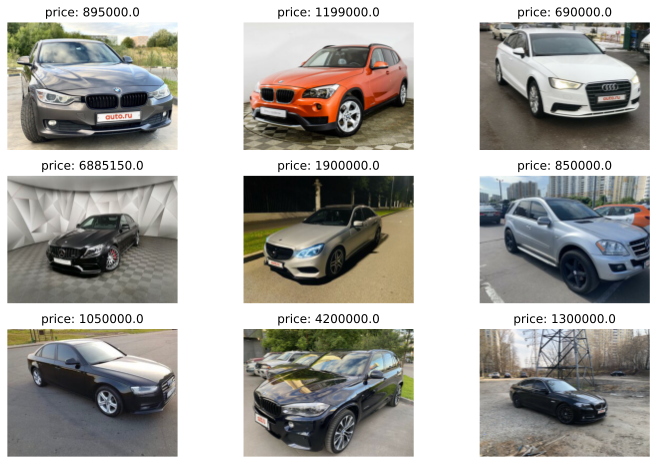

In [116]:
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [117]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

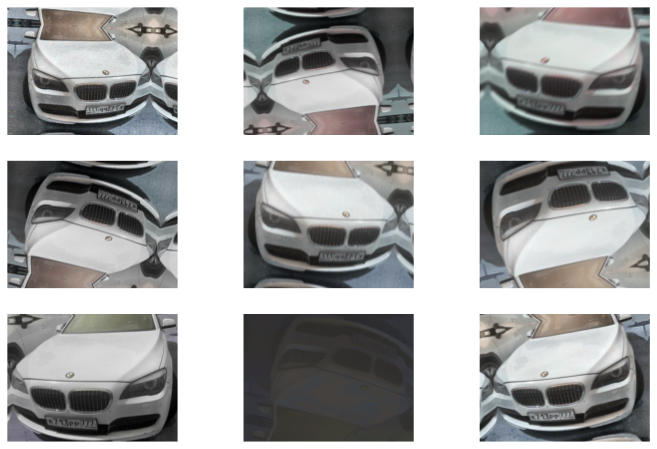

In [118]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = Compose([
    Flip(),
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# example
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [119]:
def make_augmentations(images):
  print('applying augmentation', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
# NLP part
#tokenize = Tokenizer(num_words=MAX_WORDS)
#tokenize.fit_on_texts(data_text['description'])

In [120]:
data_text['description'] = data_text['description'].apply(lambda x: ' '.join(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data_text['description'].iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data_text['description'].iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data_text['description'].iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# Check for errors:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [123]:
train_dataset

<MapDataset shapes: (((240, 320, 3), (365,), <unknown>), ()), types: ((tf.uint8, tf.float64, tf.int32), tf.float64)>

In [124]:
# Сonvolutional network for image analysis without head
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 2s 0us/step


In [125]:
# Neural network for tabular data
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [126]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [127]:
# Comine three neural networks
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# Regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [128]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [129]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [130]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 131s 689ms/step - loss: 51.1223 - MAPE: 51.1223 - val_loss: 29.7149 - val_MAPE: 29.7149
Epoch 2/100
190/190 [==============================] - 128s 676ms/step - loss: 25.2313 - MAPE: 25.2313 - val_loss: 20.2892 - val_MAPE: 20.2892
Epoch 3/100
190/190 [==============================] - 128s 672ms/step - loss: 20.9435 - MAPE: 20.9435 - val_loss: 17.2927 - val_MAPE: 17.2927
Epoch 4/100
190/190 [==============================] - 127s 666ms/step - loss: 19.0726 - MAPE: 19.0726 - val_loss: 16.2981 - val_MAPE: 16.2981
Epoch 5/100
190/190 [==============================] - 127s 670ms/step - loss: 17.8893 - MAPE: 17.8893 - val_loss: 15.5627 - val_MAPE: 15.5627
Epoch 6/100
190/190 [==============================] - 126s 666ms/step - loss: 17.0288 - MAPE: 17.0288 - val_loss: 14.9266 - val_MAPE: 14.9266
Epoch 7/100
190/190 [==============================] - 127s 667ms/step - loss: 16.4535 - MAPE: 16.4535 - val_loss: 15.2390 - val_MAPE: 15.2390

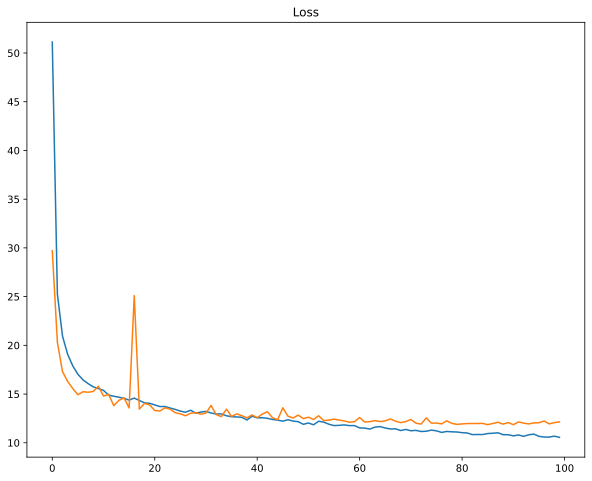

In [131]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [132]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [133]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.14%


In [134]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Model 5 + skip connections
The strongest correlation is observed between the production date of a car and its price. A wide path for this feature will be added to the model.

In [140]:
# Creatin a new dataset
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, productionDate, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, productionDate), price

def tf_process_val_dataset_element(image, table_data, text, productionDate, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, productionDate), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data_text['description'].iloc[X_train.index], X_train[['productionDate']], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data_text['description'].iloc[X_test.index], X_test[['productionDate']], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data_text['description'].iloc[X_sub.index], X_sub[['productionDate']], y_sub
    )).map(tf_process_val_dataset_element)

# Check for errors:
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [141]:
productiondate = Sequential([L.Input(shape=1, name="productiondate"), ])

combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output, productiondate.output])

# Regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model_with_skip = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input, productiondate.input], outputs=head)
model_with_skip.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [142]:
optimizer = tf.keras.optimizers.Adam(0.005)
model_with_skip.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [143]:
checkpoint = ModelCheckpoint('../working/best_model_skip.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [144]:
history_skip = model_with_skip.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 130s 686ms/step - loss: 29.7294 - MAPE: 29.7294 - val_loss: 13.6134 - val_MAPE: 13.6134
Epoch 2/100
190/190 [==============================] - 128s 674ms/step - loss: 13.1469 - MAPE: 13.1469 - val_loss: 12.7496 - val_MAPE: 12.7496
Epoch 3/100
190/190 [==============================] - 128s 671ms/step - loss: 12.1335 - MAPE: 12.1335 - val_loss: 12.5844 - val_MAPE: 12.5844
Epoch 4/100
190/190 [==============================] - 128s 674ms/step - loss: 11.6489 - MAPE: 11.6489 - val_loss: 12.0458 - val_MAPE: 12.0458
Epoch 5/100
190/190 [==============================] - 127s 668ms/step - loss: 11.3828 - MAPE: 11.3828 - val_loss: 12.1580 - val_MAPE: 12.1580
Epoch 6/100
190/190 [==============================] - 127s 670ms/step - loss: 11.4928 - MAPE: 11.4928 - val_loss: 12.2328 - val_MAPE: 12.2328
Epoch 7/100
190/190 [==============================] - 128s 673ms/step - loss: 11.1327 - MAPE: 11.1327 - val_loss: 12.0409 - val_MAPE: 12.0409

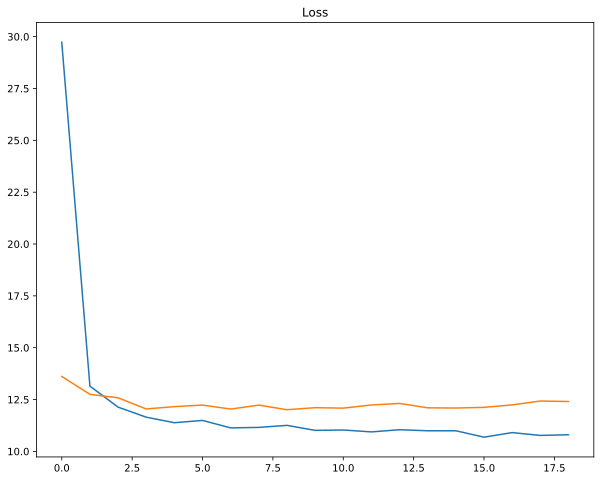

In [145]:
plt.title('Loss')
plt.plot(history_skip.history['MAPE'], label='train')
plt.plot(history_skip.history['val_MAPE'], label='test')
plt.show();

In [146]:
model_with_skip.load_weights('../working/best_model_skip.hdf5')
model_with_skip.save('../working/nn_final.hdf5')

In [147]:
test_predict_nn3_skip = model_with_skip.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3_skip[:,0]))*100:0.2f}%")

TEST mape: 12.41%


In [148]:
sub_predict_nn3_skip = model_with_skip.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3_skip[:,0]
sample_submission.to_csv('nn3_skip_submission.csv', index=False)

# Blend

In [135]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.78%


In [137]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend__submission.csv', index=False)

In [149]:
blend_skip_predict = (test_predict_catboost + test_predict_nn3_skip[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_skip_predict))*100:0.2f}%")

TEST mape: 10.91%


In [150]:
blend_skip_sub_predict = (sub_predict_catboost + sub_predict_nn3_skip[:,0]) / 2
sample_submission['price'] = blend_skip_sub_predict
sample_submission.to_csv('blend__skip_submission.csv', index=False)